### SETUP INICIAL DO PROJETO

In [82]:

#importação das bibliotecase e pacotes necessários para a análise

import json
import numpy as np
import os
import pandas as pd
import pandas_gbq as gbq
import re
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from google.cloud import bigquery
from google.cloud.bigquery_storage import BigQueryReadClient
from google.oauth2 import service_account

# Carrega o .env: onde estão as credenciais do projeto/repositório
load_dotenv("/mnt/c/Users/wrpen/OneDrive/Desktop/df_lh/.env")

# Detectar ambiente: como eu estou usando wsl-ubuntu, no VS Code  -  Windows, estava dando conflitos de path
if os.name == "nt":  # se Windows
    credentials_path = r"C:\Temp\desafiolh-445818-3cb0f62cb9ef.json"
else:  # se WSL/Linux
    credentials_path = "/mnt/c/Temp/desafiolh-445818-3cb0f62cb9ef.json"

# Parâmetros injetados pelo Papermill ou definidos manualmente, caso não existam no ambiente
# Tables_to_process: lista de tabelas que serão processadas
# Output_dataset: nome do dataset onde os dados processados serão armazenados, neste caso, raw_data_cleaned
if 'tables_to_process' not in locals():
    tables_to_process = [
        "desafioadventureworks-446600.raw_data.production-product"       
    ]

if 'output_dataset' not in locals():
    output_dataset = "desafioadventureworks-446600.raw_data_cleaned"

# Configs do cliente BigQuery: input de project e location de acordo com dados no Bigquery
credentials = service_account.Credentials.from_service_account_file(credentials_path)
client = bigquery.Client(credentials=credentials, project=os.getenv("BIGQUERY_PROJECT"), location="us-central1")


In [83]:
# Print com a tabela que vai ser processada nesse notebook

print("Tabelas a processar:", tables_to_process)

Tabelas a processar: ['desafioadventureworks-446600.raw_data.production-product']


In [84]:
# Nome do dataset no Bigquery com os dados brutos (.csv) extraídos pelo Meltano 
dataset_id = 'raw_data'
print(dataset_id)

# Lista de tabelas do dataset raw_data no Bigquery
tables = client.list_tables('raw_data')
print("Tabelas disponíveis:")
for table in tables:
    print(table.table_id)

raw_data
Tabelas disponíveis:
humanresources-employee
person-address
person-businessentity
person-person
person-stateprovince
production-location
production-product
production-productcategory
production-productinventory
production-productsubcategory
sales-customer
sales-salesorderdetail
sales-salesorderheader
sales-salesterritory
sales-store


# Exploratory Data Analysis (EDA) e Data Cleaning

### Glossário dos dados:

O termo ''doc:'', situado no rodapé de algumas cells, indica algo como:

- documentação: documentar decisões, análises e resultados;

- abreviações de termos, como bkp, df, entre outros.

In [85]:
# Configuração para que o df exiba todas as colunas e todas as linhas completas, e também, exiba o formato numérico com 2 dígitos após a vírgula

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 10000)
pd.options.display.float_format = '{:.2f}'.format


#doc: df = dataframe  

In [86]:
# Dicionário para armazenar os df processados
df_processados = {}

# Iteração das tabelas e armazenamento em df
for input_table in tables_to_process:
    print(f"Processando tabela: {input_table}")
    
    # Nome da tabela com substituição de '-' por '_'
    table_name = input_table.split(".")[-1].replace("-", "_")  
    
    # Ler os dados da tabela do BigQuery para um df
    print("Lendo os dados do BigQuery...")
    query = f"SELECT * FROM `{input_table}`"
    table_data = client.query(query).to_dataframe()
    
    # Armazenar o df no dicionário
    df_processados[table_name] = table_data
    print(f"Tabela {table_name} processada e armazenada com sucesso.")

# Print de validação
print("Todas as tabelas foram processadas com sucesso!")


Processando tabela: desafioadventureworks-446600.raw_data.production-product
Lendo os dados do BigQuery...
Tabela production_product processada e armazenada com sucesso.
Todas as tabelas foram processadas com sucesso!


In [87]:
# Listar todas as variáveis criadas dinamicamente
for table_name in df_processados.keys():
    print(f"Variável criada: {table_name}")  

Variável criada: production_product


In [88]:
# Atribuir o df a uma variável com nome mais simples
production_product = df_processados['production_product']

print(f"Colunas: {production_product.shape[1]}\nLinhas: {production_product.shape[0]}")

Colunas: 25
Linhas: 7560


In [89]:
# Identificar duplicadas com base em 'productid'
duplicadas = production_product[
    production_product.duplicated(subset=['productid'], keep=False)
]

# Verificar se existem duplicadas
if not duplicadas.empty:
    # Ordenar duplicadas por 'productid' e 'modifieddate'
    duplicadas_ordenadas = duplicadas.sort_values(by=['productid', 'modifieddate'])

    # Exibir duplicadas ordenadas
    print("duplicadas ordenadas:")
    print(duplicadas_ordenadas)
else:
    print("Não foram encontradas duplicadas.")

duplicadas ordenadas:
      productid                name productnumber  makeflag  finishedgoodsflag  color  safetystocklevel  reorderpoint  standardcost  listprice  size sizeunitmeasurecode weightunitmeasurecode  weight  daystomanufacture productline class style  productsubcategoryid  productmodelid             sellstartdate sellenddate discontinueddate                               rowguid                     modifieddate
0             1     Adjustable Race       AR-5381     False              False   None              1000           750          0.00       0.00  None                None                  None     NaN                  0        None  None  None                  <NA>            <NA> 2008-04-30 00:00:00+00:00         NaT             None  694215b7-08f7-4c0d-acb1-d734ba44c0c8 2014-02-08 10:01:36.827000+00:00
1             1     Adjustable Race       AR-5381     False              False   None              1000           750          0.00       0.00  None                No

In [90]:
# Remover duplicadas mantendo a última ocorrência com base em 'modifieddate', pois ela que indica a data da última modificação nos dados
# Importante, pois se houver erro na ingestão (duplicação), mantém os dados integros.

production_product = production_product.drop_duplicates(subset=['productid'], keep='last')

print(f"Linhas após remover duplicadas (baseando-se na última 'modifieddate'): {len(production_product)}")

#bkp dos dados brutos
raw_data_bkp_2_sem_duplicadas = production_product.copy()


#doc: bkp = backup (cópia)

Linhas após remover duplicadas (baseando-se na última 'modifieddate'): 504


In [91]:
# Ordenar e exibir o df por 'productid'
production_product = production_product.sort_values(by=['productid'])

print(production_product)

      productid                   name productnumber  makeflag  finishedgoodsflag  color  safetystocklevel  reorderpoint  standardcost  listprice  size sizeunitmeasurecode weightunitmeasurecode  weight  daystomanufacture productline class style  productsubcategoryid  productmodelid             sellstartdate sellenddate discontinueddate                               rowguid                     modifieddate
5044          1        Adjustable Race       AR-5381     False              False   None              1000           750          0.00       0.00  None                None                  None     NaN                  0        None  None  None                  <NA>            <NA> 2008-04-30 00:00:00+00:00         NaT             None  694215b7-08f7-4c0d-acb1-d734ba44c0c8 2014-02-08 10:01:36.827000+00:00
5049          2           Bearing Ball       BA-8327     False              False   None              1000           750          0.00       0.00  None                None           

In [92]:
# Iterar por todas as colunas do df, para verificar valores ausentes

# Verificar valores ausentes na coluna
for column in production_product.columns:   
    missing_rows = production_product[production_product[column].isnull()]
    print(f"Coluna '{column}': {missing_rows.shape[0]} linhas ausentes.")
    
# Mostrar as primeiras linhas ausentes, se preciso for, limitar o head() para dar menos outputs ou limitar os outputs
    if not missing_rows.empty:
        print(f"Exibindo as primeiras linhas com valores ausentes em '{column}':")
        print(missing_rows.head(), "\n")
    else:
        print(f"Nenhuma linha com valores ausentes em '{column}'.\n")



#doc: apesar de apresentar várias colunas com muitas linhas ausentes, não há a necessidade de tratá-las, pois não interferem negativamente à análise        

Coluna 'productid': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'productid'.

Coluna 'name': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'name'.

Coluna 'productnumber': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'productnumber'.

Coluna 'makeflag': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'makeflag'.

Coluna 'finishedgoodsflag': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'finishedgoodsflag'.

Coluna 'color': 248 linhas ausentes.
Exibindo as primeiras linhas com valores ausentes em 'color':
      productid                   name productnumber  makeflag  finishedgoodsflag color  safetystocklevel  reorderpoint  standardcost  listprice  size sizeunitmeasurecode weightunitmeasurecode  weight  daystomanufacture productline class style  productsubcategoryid  productmodelid             sellstartdate sellenddate discontinueddate                               rowguid                     modifieddate
5044          1        Adj

In [93]:
# Valores únicos por coluna, para verificar se colunas como flags, normalmente booleanas, possuem apenas 1 ou 2 valores.

valores_unicos = production_product.nunique(dropna=False)

print("Valores únicos incluindo NaN:")
print(valores_unicos)



Valores únicos incluindo NaN:
productid                504
name                     504
productnumber            504
makeflag                   2
finishedgoodsflag          2
color                     10
safetystocklevel           6
reorderpoint               6
standardcost             114
listprice                103
size                      19
sizeunitmeasurecode        2
weightunitmeasurecode      3
weight                   128
daystomanufacture          4
productline                5
class                      4
style                      4
productsubcategoryid      38
productmodelid           120
sellstartdate              4
sellenddate                3
discontinueddate           1
rowguid                  504
modifieddate               2
dtype: int64


In [94]:
# Verificar se a coluna é toda nula
is_all_null = production_product['discontinueddate'].isnull().all()
if is_all_null:
    print("A coluna 'discontinueddate' é completamente NULL.")
else:
    print("A coluna 'discontinueddate' possui valores não nulos.")


A coluna 'discontinueddate' é completamente NULL.


In [95]:
# Remover a coluna 'discontinueddate' por ser completamente NULL
production_product.drop(columns=['discontinueddate'], inplace=True)


In [96]:
# Listar colunas binárias esperadas e verificar valores únicos e suas distribuições
coluna_binaria = ['makeflag', 'finishedgoodsflag']

for col in coluna_binaria:
    unique_values = production_product[col].unique()
    print(f"Valores únicos em '{col}': {unique_values}")
    print(f"Distribuição de '{col}':")
    print(production_product[col].value_counts())
    print()


#doc: garantir que colunas binárias contenham apenas valores esperados, no caso True ou False e identificar anomalias verificando os valores únicos em cada coluna; valores fora do padrão binário, facilitando a validação e correção


Valores únicos em 'makeflag': <BooleanArray>
[False, True]
Length: 2, dtype: boolean
Distribuição de 'makeflag':
makeflag
False    265
True     239
Name: count, dtype: Int64

Valores únicos em 'finishedgoodsflag': <BooleanArray>
[False, True]
Length: 2, dtype: boolean
Distribuição de 'finishedgoodsflag':
finishedgoodsflag
True     295
False    209
Name: count, dtype: Int64



In [97]:
#verificar informações do df
production_product.info()

<class 'pandas.core.frame.DataFrame'>
Index: 504 entries, 5044 to 6259
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   productid              504 non-null    Int64              
 1   name                   504 non-null    object             
 2   productnumber          504 non-null    object             
 3   makeflag               504 non-null    boolean            
 4   finishedgoodsflag      504 non-null    boolean            
 5   color                  256 non-null    object             
 6   safetystocklevel       504 non-null    Int64              
 7   reorderpoint           504 non-null    Int64              
 8   standardcost           504 non-null    float64            
 9   listprice              504 non-null    float64            
 10  size                   211 non-null    object             
 11  sizeunitmeasurecode    176 non-null    object             


In [98]:
# Avaliando as variáveis qualitativas

coluna_qualitativa = ["color", "size", "sizeunitmeasurecode", "weightunitmeasurecode", "productline", "class", "style"]

for col in coluna_qualitativa:
    counts = production_product[col].value_counts().nlargest(10)
    percentages = (counts / production_product.shape[0] * 100).map("{:.2f}%".format)
    summary = pd.DataFrame({"qtde.": counts, "%": percentages})
    print(f"Análise da coluna '{col}':")
    print(summary)
    print("\n")


#doc: qdte. = quantidade
#doc*: variáveis qualitativas são um tipo de variável estatística que representam características ou atributos dos dados, sem serem medidas numericamente no nosso caso, city, por exemplo

Análise da coluna 'color':
              qtde.       %
color                      
Black            93  18.45%
Silver           43   8.53%
Red              38   7.54%
Yellow           36   7.14%
Blue             26   5.16%
Multi             8   1.59%
Silver/Black      7   1.39%
White             4   0.79%
Grey              1   0.20%


Análise da coluna 'size':
      qtde.      %
size              
44       29  5.75%
48       25  4.96%
52       16  3.17%
58       15  2.98%
42       15  2.98%
38       12  2.38%
L        11  2.18%
40       11  2.18%
62       11  2.18%
M        11  2.18%


Análise da coluna 'sizeunitmeasurecode':
                     qtde.       %
sizeunitmeasurecode               
CM                     176  34.92%


Análise da coluna 'weightunitmeasurecode':
                       qtde.       %
weightunitmeasurecode               
LB                       176  34.92%
G                         29   5.75%


Análise da coluna 'productline':
             qtde.       %
produc

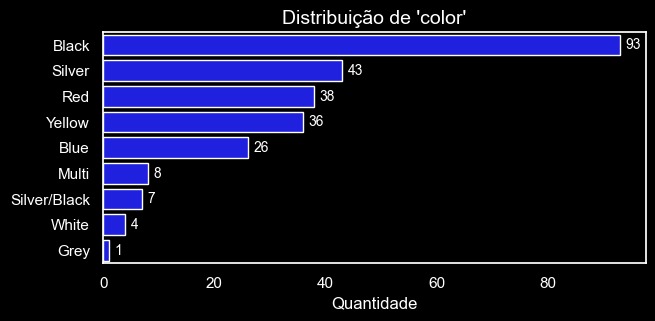

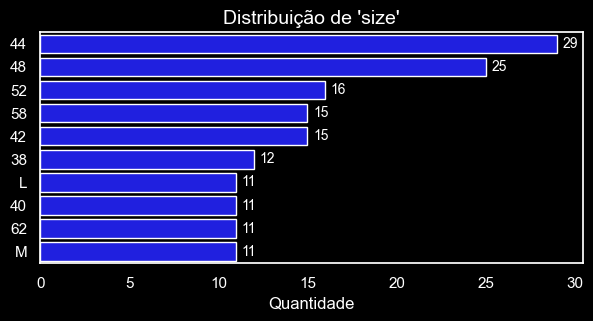

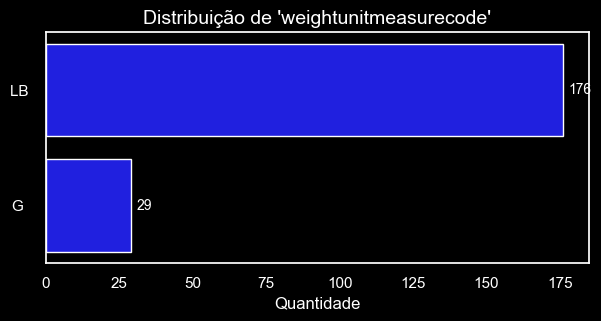

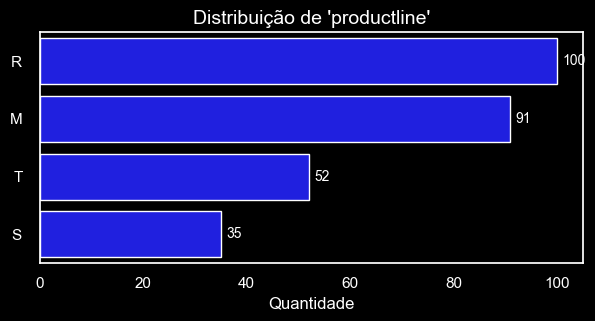

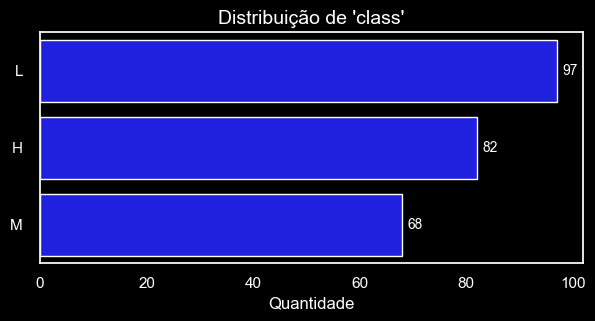

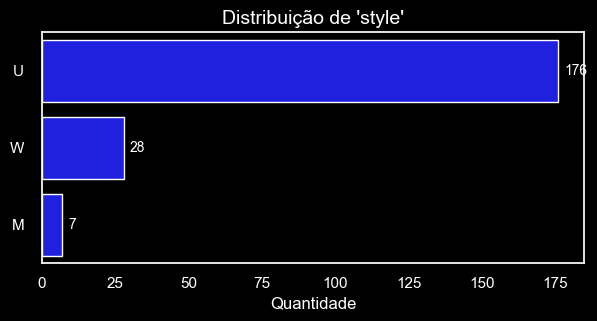

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar o estilo do gráfico para fundo escuro
sns.set(style='darkgrid', rc={"axes.facecolor": "black", "figure.facecolor": "black"})

coluna_qualitativa = ["color", "size", "weightunitmeasurecode", "productline", "class", "style"]

for col in coluna_qualitativa:
    counts = production_product[col].value_counts().nlargest(10)  # Top 10 categorias
    percentages = (counts / production_product.shape[0] * 100).map("{:.2f}%".format)
    summary = pd.DataFrame({"qtde.": counts, "%": percentages})
    
    # Criar o gráfico
    plt.figure(figsize=(7, 3))
    ax = sns.barplot(x=summary["qtde."], y=summary.index, color="blue")  
    
    # Títulos e rótulos
    plt.title(f"Distribuição de '{col}'", color='white', fontsize=14)
    plt.xlabel("Quantidade", color='white', fontsize=12)
    plt.ylabel("", color='white', fontsize=12)
    
    # Ajustar cores e rótulos
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    
    # Adicionar os valores na frente das barras
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', color='white', fontsize=10, padding=4)
    
    # Remover a grade
    ax.grid(False)
    
    plt.show()


In [100]:
#verificar informações do df
production_product.info()

<class 'pandas.core.frame.DataFrame'>
Index: 504 entries, 5044 to 6259
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   productid              504 non-null    Int64              
 1   name                   504 non-null    object             
 2   productnumber          504 non-null    object             
 3   makeflag               504 non-null    boolean            
 4   finishedgoodsflag      504 non-null    boolean            
 5   color                  256 non-null    object             
 6   safetystocklevel       504 non-null    Int64              
 7   reorderpoint           504 non-null    Int64              
 8   standardcost           504 non-null    float64            
 9   listprice              504 non-null    float64            
 10  size                   211 non-null    object             
 11  sizeunitmeasurecode    176 non-null    object             


In [101]:
# Variáveis quantitativas*: 

# Identificar colunas numéricas para análise de outliers
numeric_columns = ['safetystocklevel', 'reorderpoint', 'standardcost', 'listprice', 'weight', 'daystomanufacture']

# Estatísticas Descritivas das colunas numéricas**
print("Estatísticas Descritivas:")
print(production_product[numeric_columns].describe())

# Cálculo de limites para outliers (IQR)***
for col in numeric_columns:
    q1 = production_product[col].quantile(0.25)
    q3 = production_product[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Exibir os limites
    print(f"\nColuna: {col}")
    print(f"Limite inferior: {lower_bound}, Limite superior: {upper_bound}")
    
    # Detecção e Análise de Outliers****
    outliers = production_product[(production_product[col] < lower_bound) | (production_product[col] > upper_bound)]
    print(f"Outliers detectados ({len(outliers)}):")
    print(outliers[[col]])



#doc*: variáveis quantitativas são um tipo de dado que pode ser representado por números e medidas objetivas, no nosso caso, vacationhours, sickleavehours, por exemplo
#doc**: realizar estatísticas descritivas para entender a centralidade e variação dos dados (valores médios, mínimos, máximos, etc.)
#doc***: calcular limites para identificar outliers (valores extremos que podem indicar erros ou casos excepcionais nos dados)
#doc****: verificar a existência de outliers para decidir ações como remoção, substituição ou tratamento, garantindo qualidade dos dados


Estatísticas Descritivas:
       safetystocklevel  reorderpoint  standardcost  listprice  weight  daystomanufacture
count            504.00        504.00        504.00     504.00  205.00             504.00
mean             535.15        401.36        258.60     438.67   74.07               1.10
std              374.11        280.58        461.63     773.60  182.17               1.49
min                4.00          3.00          0.00       0.00    2.12               0.00
25%              100.00         75.00          0.00       0.00    2.88               0.00
50%              500.00        375.00         23.37      49.99   17.90               1.00
75%             1000.00        750.00        317.08     564.99   27.35               1.00
max             1000.00        750.00       2171.29    3578.27 1050.00               4.00

Coluna: safetystocklevel
Limite inferior: -1250.0, Limite superior: 2350.0
Outliers detectados (0):
Empty DataFrame
Columns: [safetystocklevel]
Index: []

Coluna: 

c:\Users\wrpen\OneDrive\Desktop\df_lh\.venv\lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)
c:\Users\wrpen\OneDrive\Desktop\df_lh\.venv\lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)
c:\Users\wrpen\OneDrive\Desktop\df_lh\.venv\lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)
c:\Users\wrpen\OneDrive\Desktop\df_lh\.venv\lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


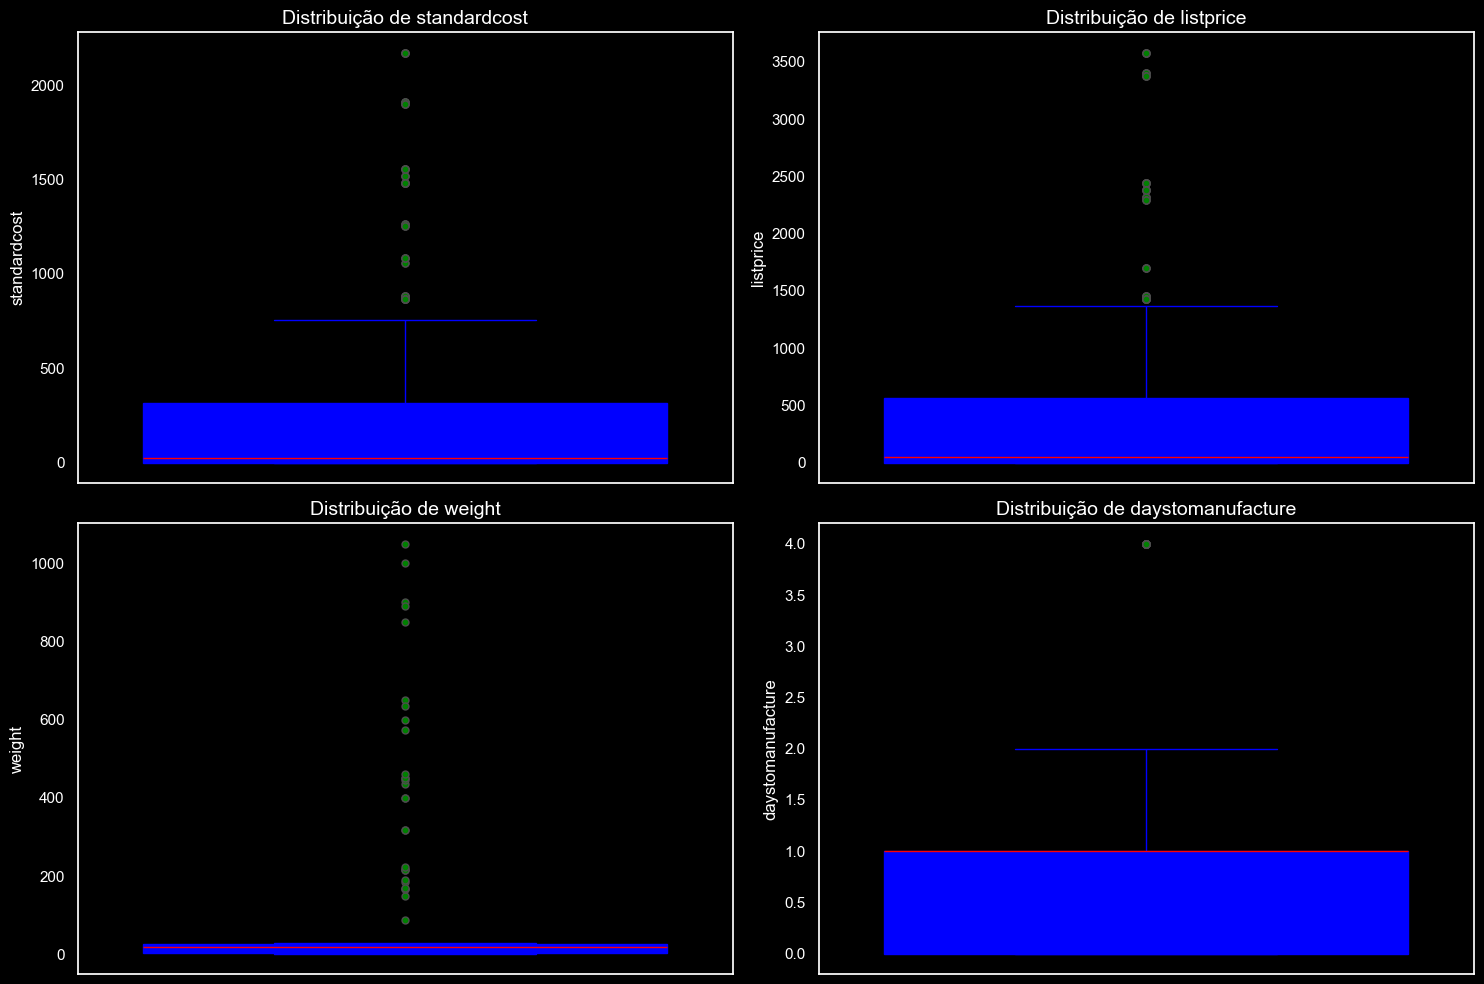

In [102]:
# Lista de variáveis com outliers
variables_with_outliers = ['standardcost', 'listprice', 'weight', 'daystomanufacture']

# Configurar o layout da grade
fig, axes = plt.subplots(2, 2, figsize=(15, 10))  # 2x2 grid
axes = axes.flatten()  # Para facilitar o acesso aos eixos

# Criar os gráficos
for i, var in enumerate(variables_with_outliers):
    ax = sns.boxplot(
        y=production_product[var],
        color="blue",
        boxprops={"color": "blue"}, whiskerprops={"color": "blue"}, capprops={"color": "blue"},
        medianprops={"color": "red"}, flierprops={"markerfacecolor": "green", "markersize": 5},
        ax=axes[i]
    )
    
    ax.set_title(f'Distribuição de {var}', color='white', fontsize=14)
    ax.set_ylabel(var, color='white', fontsize=12)
    ax.set_xlabel("")
    
    # Ajustar as cores dos ticks
    ax.tick_params(axis='y', colors='white')
    ax.tick_params(axis='x', colors='white')
    
    # Remover a grade (opcional)
    ax.grid(False)

# Ajustar o layout para evitar sobreposição
plt.tight_layout()
plt.show()


#doc*****: de acordo com os resultados, as colunas safetystocklevel e reorderpoint não há necessidade de tratamento, sem outliers
#          standardcost: 55 outliers acima de 792.69, o que pode ser aceitos, pois podem efletir produtos premium ou com custos elevados de produção
#          listprice: Também identificados 55 outliers acima de 1412.47. Isso é esperado, já que produtos com custo alto podem ter preços elevados
#          daystomanufacture: detectados 97 outliers acima de 2.5 dias. Esses valores (ex.: 4 dias) podem ser válidos para produtos mais complexos ou com maior tempo de produção

In [103]:
#Verificando os outliers de da coluna weight: valores muito elevados para os componentes

# Calcular os limites para a coluna weight
q1 = production_product['weight'].quantile(0.25)
q3 = production_product['weight'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filtrar valores que ultrapassam os limites
outliers_weight = production_product[
    (production_product['weight'] < lower_bound) | 
    (production_product['weight'] > upper_bound)
]

# Ordenar os outliers por weight em ordem decrescente
outliers_weight_sorted = outliers_weight[['productid', 'name', 'weight']].sort_values(by='weight', ascending=False)

# Exibir os valores
print(outliers_weight_sorted)


      productid                 name  weight
7224        826   LL Road Rear Wheel 1050.00
7229        827   ML Road Rear Wheel 1000.00
7189        818  LL Road Front Wheel  900.00
7234        828   HL Road Rear Wheel  890.00
7194        819  ML Road Front Wheel  850.00
7199        820  HL Road Front Wheel  650.00
6649        950          ML Crankset  635.00
6644        949          LL Crankset  600.00
6654        951          HL Crankset  575.00
5974        513          Touring Rim  460.00
5964        511          ML Road Rim  450.00
5949        508      ML Mountain Rim  450.00
5959        510          LL Road Rim  445.00
5944        507      LL Mountain Rim  435.00
5969        512          HL Road Rim  400.00
5954        509      HL Mountain Rim  400.00
6629        948         Front Brakes  317.00
6634        907          Rear Brakes  317.00
6614        994    LL Bottom Bracket  223.00
6839        935    LL Mountain Pedal  218.00
6844        936    ML Mountain Pedal  215.00
6664      

In [104]:
# Categorias de produtos com outliers em 'weight'
categories_with_outliers = outliers_weight.groupby('name')['weight'].mean().sort_values(ascending=False)

# Exibir categorias com peso médio para revisão
print(categories_with_outliers)


#doc:uma lista de nomes de produtos (ex.: "LL Road Rear Wheel", "ML Crankset") e seus pesos médios; 
#    visão consolidada para validar quais categorias têm valores incoerentes

name
LL Road Rear Wheel    1050.00
ML Road Rear Wheel    1000.00
LL Road Front Wheel    900.00
HL Road Rear Wheel     890.00
ML Road Front Wheel    850.00
HL Road Front Wheel    650.00
ML Crankset            635.00
LL Crankset            600.00
HL Crankset            575.00
Touring Rim            460.00
ML Road Rim            450.00
ML Mountain Rim        450.00
LL Road Rim            445.00
LL Mountain Rim        435.00
HL Mountain Rim        400.00
HL Road Rim            400.00
Rear Brakes            317.00
Front Brakes           317.00
LL Bottom Bracket      223.00
LL Mountain Pedal      218.00
ML Mountain Pedal      215.00
Rear Derailleur        215.00
LL Road Pedal          189.00
HL Mountain Pedal      185.00
HL Bottom Bracket      170.00
ML Bottom Bracket      168.00
ML Road Pedal          168.00
HL Road Pedal          149.00
Front Derailleur        88.00
Name: weight, dtype: float64


In [105]:
# Definir valores aproximados por categoria (em kg)
weight_corrections = {
    "LL Road Rear Wheel": 1.5,
    "ML Road Rear Wheel": 1.5,
    "LL Road Front Wheel": 1.2,
    "HL Road Rear Wheel": 1.5,
    "ML Road Front Wheel": 1.2,
    "HL Road Front Wheel": 1.2,
    "ML Crankset": 1.0,
    "LL Crankset": 1.0,
    "HL Crankset": 1.0,
    "Touring Rim": 0.7,
    "ML Road Rim": 0.7,
    "ML Mountain Rim": 0.8,
    "LL Road Rim": 0.7,
    "LL Mountain Rim": 0.8,
    "HL Mountain Rim": 0.8,
    "HL Road Rim": 0.7,
    "Rear Brakes": 0.3,
    "Front Brakes": 0.3,
    "LL Bottom Bracket": 0.4,
    "LL Mountain Pedal": 0.4,
    "ML Mountain Pedal": 0.4,
    "Rear Derailleur": 0.5,
    "LL Road Pedal": 0.3,
    "HL Mountain Pedal": 0.4,
    "HL Bottom Bracket": 0.4,
    "ML Bottom Bracket": 0.4,
    "ML Road Pedal": 0.3,
    "HL Road Pedal": 0.3,
    "Front Derailleur": 0.3,
}


In [106]:
# Aplicar correções no DataFrame
production_product['weight_corrected'] = production_product['name'].map(weight_corrections).fillna(production_product['weight'])

# Verificar os resultados
print(production_product[['name', 'weight', 'weight_corrected']].sort_values(by='weight', ascending=False).head(20))


# Correção de valores inconsistentes na coluna 'weight'

# 1. Identificação de inconsistências
# Durante a análise, algumas categorias de produtos apresentavam valores de peso incoerentes com a realidade, como rodas com 1050 kg e cranksets com 635 kg. 
# Esses valores foram considerados erros de entrada de dados.

# 2. Definição de pesos aproximados
# Foi criado um dicionário chamado 'weight_corrections' contendo valores aproximados para cada
# categoria de produto com base em características reais de produtos similares. Esses valores
# representam estimativas coerentes dentro do domínio de produtos da Adventure Works.

# 3. Aplicação das correções
# Os valores inconsistentes foram substituídos pelos valores definidos no dicionário.
# Para isso, a função 'map()' foi utilizada para associar os valores corrigidos às categorias
# específicas, criando uma nova coluna chamada 'weight_corrected'.
# Caso um produto não estivesse no dicionário de correções, o valor original foi mantido.

# 4. Resultado
# A nova coluna 'weight_corrected' foi criada, contendo os valores ajustados.
# Agora, essa coluna pode ser utilizada para análises e exportação, enquanto a coluna original
# 'weight' pode ser mantida para rastreamento e auditoria, se necessário.

                     name  weight  weight_corrected
7224   LL Road Rear Wheel 1050.00              1.50
7229   ML Road Rear Wheel 1000.00              1.50
7189  LL Road Front Wheel  900.00              1.20
7234   HL Road Rear Wheel  890.00              1.50
7194  ML Road Front Wheel  850.00              1.20
7199  HL Road Front Wheel  650.00              1.20
6649          ML Crankset  635.00              1.00
6644          LL Crankset  600.00              1.00
6654          HL Crankset  575.00              1.00
5974          Touring Rim  460.00              0.70
5964          ML Road Rim  450.00              0.70
5949      ML Mountain Rim  450.00              0.80
5959          LL Road Rim  445.00              0.70
5944      LL Mountain Rim  435.00              0.80
5954      HL Mountain Rim  400.00              0.80
5969          HL Road Rim  400.00              0.70
6634          Rear Brakes  317.00              0.30
6629         Front Brakes  317.00              0.30
6614    LL B

In [107]:
# Reorganizar as colunas no DataFrame para que weight_corrected fique ao lado de weight
cols = production_product.columns.tolist()
if 'weight' in cols and 'weight_corrected' in cols:
    weight_index = cols.index('weight')
    cols.insert(weight_index + 1, cols.pop(cols.index('weight_corrected')))
production_product = production_product[cols]

# Verificar as colunas reorganizadas
print(production_product.columns)


Index(['productid', 'name', 'productnumber', 'makeflag', 'finishedgoodsflag', 'color', 'safetystocklevel', 'reorderpoint', 'standardcost', 'listprice', 'size', 'sizeunitmeasurecode', 'weightunitmeasurecode', 'weight', 'weight_corrected', 'daystomanufacture', 'productline', 'class', 'style', 'productsubcategoryid', 'productmodelid', 'sellstartdate', 'sellenddate', 'rowguid', 'modifieddate'], dtype='object')


In [108]:
# Atualizar o dicionário df_processados com o df ajustado
df_processados['production_product'] = production_product

In [109]:
# Padronizar colunas com valores textuais
production_product['name'] = production_product['name'].str.strip().str.upper()
production_product['productnumber'] = production_product['productnumber'].str.strip().str.upper()
production_product['color'] = production_product['color'].str.strip().str.upper()
production_product['weightunitmeasurecode'] = production_product['weightunitmeasurecode'].str.strip().str.upper()
production_product['productline'] = production_product['productline'].str.strip().str.upper()
production_product['class'] = production_product['class'].str.strip().str.upper()
production_product['size'] = production_product['size'].str.strip().str.upper()
production_product['rowguid'] = production_product['rowguid'].str.strip().str.upper()

print(production_product.head())

#doc: padronizar as strings nessa etapa, contribui para a execução das demais etapas do pipeline

      productid                   name productnumber  makeflag  finishedgoodsflag color  safetystocklevel  reorderpoint  standardcost  listprice  size sizeunitmeasurecode weightunitmeasurecode  weight  weight_corrected  daystomanufacture productline class style  productsubcategoryid  productmodelid             sellstartdate sellenddate                               rowguid                     modifieddate
5044          1        ADJUSTABLE RACE       AR-5381     False              False  None              1000           750          0.00       0.00  None                None                  None     NaN               NaN                  0        None  None  None                  <NA>            <NA> 2008-04-30 00:00:00+00:00         NaT  694215B7-08F7-4C0D-ACB1-D734BA44C0C8 2014-02-08 10:01:36.827000+00:00
5049          2           BEARING BALL       BA-8327     False              False  None              1000           750          0.00       0.00  None                None            

In [110]:

# Garantir que apenas tabelas únicas sejam exportadas
unique_df_processados = {k: v for k, v in df_processados.items()}

# Exportar tabelas para o BigQuery
for table_name, df_cleaned in unique_df_processados.items():
    # Nome da tabela no BigQuery
    output_table = f"{output_dataset}.{table_name}"

    # Configurar job de exportação
    job_config = bigquery.LoadJobConfig(
        write_disposition="WRITE_TRUNCATE"  
    )
    
    # Exportar DataFrame para o BigQuery
    job = client.load_table_from_dataframe(df_cleaned, output_table, job_config=job_config)
    job.result()

    print(f"Tabela {table_name} exportada com sucesso para {output_table}.")

Tabela production_product exportada com sucesso para desafioadventureworks-446600.raw_data_cleaned.production_product.
